<a href="https://colab.research.google.com/github/SaraGul0111/SaraGul/blob/main/Cats_VS_Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Project by Sara Gul***

# Overview
This project showcases an innovative approach to image classification, specifically distinguishing between cats and dogs. By employing advanced Convolutional Neural Networks (CNNs), this solution offers high accuracy and efficiency in identifying and categorizing images. The focus is on transforming complex image data into clear, actionable insights, highlighting a commitment to precision and advanced deep learning techniques.



# Step 1: Set up Kaggle API and download the dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Step 2: Unzip the dataset

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Step 3: Import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# Step 4: Load and preprocess the data

In [ ]:
training_data = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)


Found 20000 files belonging to 2 classes.


In [ ]:
Validation_data = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 5000 files belonging to 2 classes.


###Normalization
To convert all pixel values ranging between 0 and 1

In [ ]:
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

training_data = training_data.map(process)
Validation_data = Validation_data.map(process)

# Step 5: Build the model

###Conv2D layers:
 These layers apply convolution operations to the input images, allowing the model to learn various features such as edges, textures, and patterns.

###MaxPooling2D layers:
These layers downsample the feature maps, reducing their dimensions and helping to retain only the most important information while making the model more computationally efficient.

### Dropout
Purpose: Dropout is a regularization technique used to prevent overfitting in neural networks.
specified a dropout rate of 0.3, which means that 30% of the neurons in the layer are randomly set to 0 during each training step.

###Flatten layer:
This layer transforms the 2D feature maps into a 1D vector, making it suitable for the fully connected Dense layers that follow.

###Dense layers:
These layers perform the final classification by combining the features learned by previous layers and outputting the probabilities for each class.

###Kernel Regularizer (L2 Regularization)
Purpose: Regularization is another technique used to prevent overfitting by penalizing large weights in the neural network.
specified an L2 regularization parameter of 0.001, which means that the penalty is proportional to 0.001 times the sum of the squared weights. This helps in maintaining smaller weights and discourages the network from fitting too closely to the training data.

In [ ]:
model = models.Sequential([
layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)),
layers.MaxPooling2D((2, 2), strides=2, padding='valid'),
layers.Dropout(0.3),  # Dropout to prevent overfitting

layers.Conv2D(64, (3, 3), padding='valid', activation='relu'),
layers.MaxPooling2D((2, 2), strides=2, padding='valid'),
layers.Dropout(0.3),  # Dropout to prevent overfitting

layers.Conv2D(128, (3, 3), padding='valid', activation='relu'),
layers.MaxPooling2D((2, 2), strides=2, padding='valid'),
layers.Dropout(0.3),  # Dropout to prevent overfitting

layers.Flatten(),

layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),  # L2 regularization to prevent overfitting
layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),   # L2 regularization to prevent overfitting
layers.Dense(1, activation='sigmoid')  # Output layer
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

# Step 6: Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 7: Set up callbacks for early stopping and model checkpointing


###EarlyStopping:
Stops training when the validation loss has stopped improving for a specified number of epochs (patience=5), and restores the model weights from the epoch with the best validation loss.


###ModelCheckpoint:
Saves the model to a file ('best_model.h5') whenever the validation loss improves, ensuring that the best model is preserved during training.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Step 8: Define a learning rate scheduler
###Benefits of Using a Learning Rate Scheduler


1.   Faster Convergence: Higher learning rates at the beginning help the model converge quickly.
2.   Avoid Overshooting: Reducing the learning rate over time helps avoid overshooting the minimum of the loss function, allowing finer adjustments.

1.   Improved Performance: A dynamic learning rate can lead to better final model performance by ensuring the model settles into a good minimum.
2.   Prevent Overfitting: Lower learning rates towards the end of training can prevent the model from making large updates, thus reducing the risk of overfitting.





In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Step 9: Train the model

In [ ]:
hist = model.fit(training_data,
                 epochs=50,
                 validation_data= Validation_data,
                 callbacks=[early_stopping, model_checkpoint, lr_scheduler])

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.7680 - accuracy: 0.5745

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 86s 132ms/step - loss: 0.7680 - accuracy: 0.5745 - val_loss: 0.6583 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 80s 128ms/step - loss: 0.6374 - accuracy: 0.6921 - val_loss: 0.6115 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 80s 127ms/step - loss: 0.5901 - accuracy: 0.7398 - val_loss: 0.5625 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 80s 126ms/step - loss: 0.5497 - accuracy: 0.7671 - val_loss: 0.5290 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 83s 132ms/step - loss: 0.5193 - accuracy: 0.7898 - val_loss: 0.5145 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 82s 131ms/step - loss: 0.4969 - accuracy: 0.8077 - val_loss: 0.5039 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 82s 131ms

# Step 10: Plot training and validation accuracy and loss

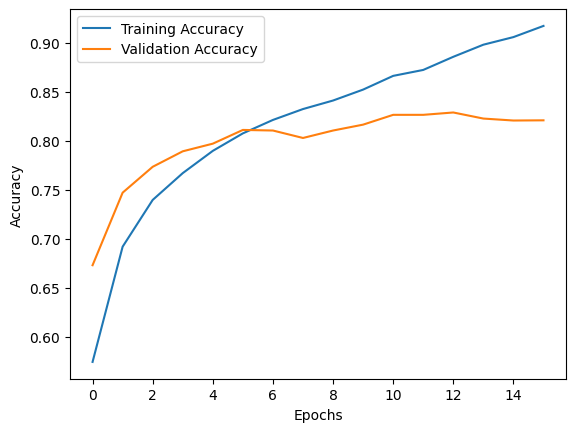

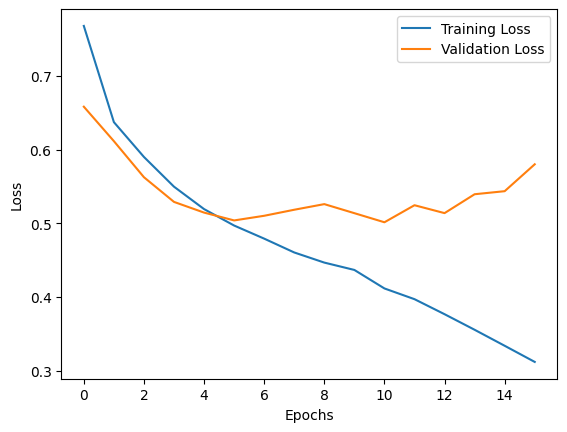

In [ ]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 11: Evaluate the model


In [ ]:
val_loss, val_acc = model.evaluate(Validation_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

157/157 [==============================] - 9s 54ms/step - loss: 0.5014 - accuracy: 0.8266
Validation Loss: 0.5013747215270996
Validation Accuracy: 0.8266000151634216


# Step 12: Predict and visualize predictions on validation data

1/1 [==============================] - 0s 67ms/step


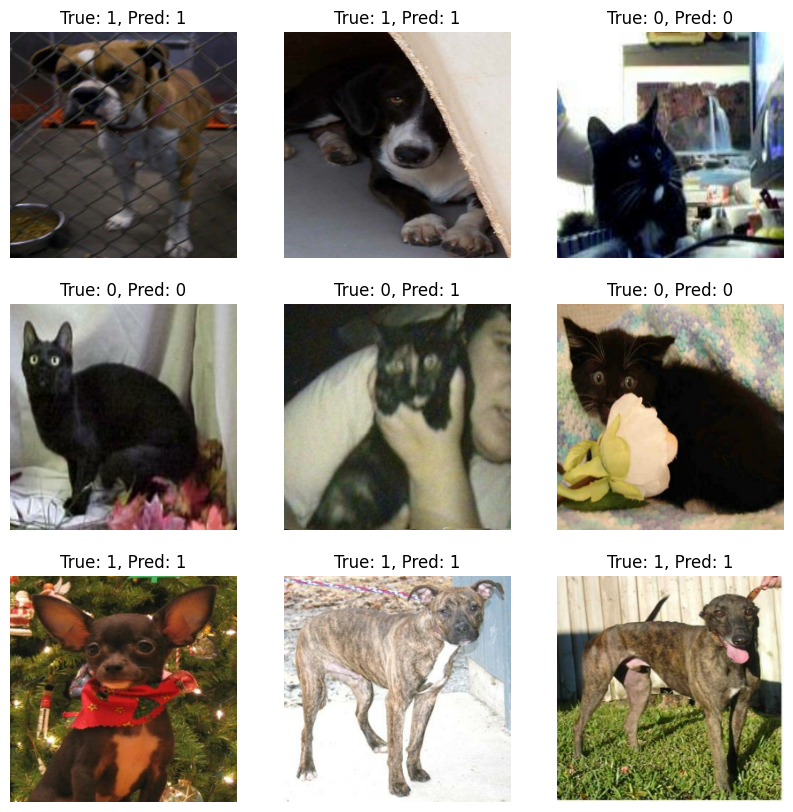

In [ ]:
def denormalize_image(image):
    image = image * 255
    return image.numpy().astype("uint8")

for images, labels in Validation_data.take(1):
    predictions = model.predict(images)
    predicted_labels = (predictions > 0.5).astype(int)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = denormalize_image(images[i])
        plt.imshow(img)
        plt.title(f"True: {labels[i]}, Pred: {predicted_labels[i][0]}")
        plt.axis("off")
    plt.show()



# Step 13: Save the model

In [ ]:
model.save('cats_dogs_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 14: Predict an external image

1/1 [==============================] - 0s 18ms/step
Prediction: [[0.85298914]]
Predicted Label: Dog


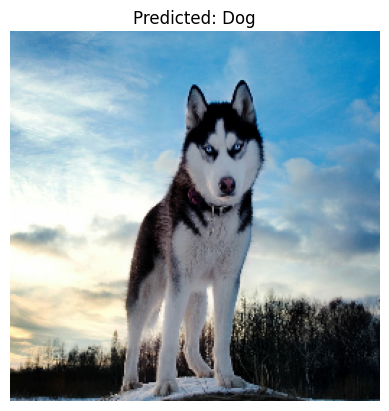

In [ ]:
image_path = '/content/External image.jpg'
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def predict_and_display(image_path, model):
    image = load_and_preprocess_image(image_path)
    prediction = model.predict(image)
    print("Prediction:", prediction)
    predicted_label = 'Dog' if prediction[0] > 0.5 else 'Cat'
    print("Predicted Label:", predicted_label)

    plt.imshow(image[0])  # Remove batch dimension for display
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

predict_and_display(image_path, model)